In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.4 MB/s 


In [ ]:
!pip install -q "tqdm>=4.36.1"

In [ ]:
!pip install -U efficientnet

     |████████████████████████████████| 50 kB 2.9 MB/s 


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import zipfile
import pandas as pd
import numpy as np
import pickle
from sklearn.utils import class_weight
from keras import regularizers
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import tensorflow_datasets as tfds
import tqdm
import tensorflow_addons as tfa
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
import os
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import shutil
import matplotlib.pyplot as plt
import cv2 as cv2
from google.colab.patches import cv2_imshow

import efficientnet.keras as efn

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!unzip -q "/content/drive/Shareddrives/DeepLearningProject/dataset_Pretrained_200/trainingSet.zip" -d "/content"

In [ ]:
!unzip -q "/content/drive/Shareddrives/DeepLearningProject/dataset_Pretrained_200/validationSet.zip" -d "/content"

In [ ]:
!unzip -q "/content/drive/Shareddrives/DeepLearningProject/testSet.zip" -d "/content"

In [ ]:
!rm -r "/content/trainingSet/"
!rm -r "/content/testSet/"
!rm -r "/content/validationSet/"

rm: cannot remove '/content/testSet/': No such file or directory


# Import training validation test

In [ ]:
BATCH_SIZE = 100
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [ ]:
training_dir = PATH = '/content/trainingSet/'
validation_dir = PATH = '/content/validationSet/'

training_dataset = tf.keras.utils.image_dataset_from_directory(
  training_dir,
  label_mode="categorical",
  labels="inferred",
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
  validation_dir,
  label_mode="categorical",
  labels="inferred",
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)


Found 1000 files belonging to 5 classes.
Found 3510 files belonging to 5 classes.


In [ ]:
test_dir = PATH = '/content/testSet/'

test_dataset = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  label_mode="categorical",
  labels="inferred",
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)

Found 53576 files belonging to 5 classes.


In [ ]:
data_augmentation = keras.Sequential(
  [
  layers.RandomFlip("vertical"),
  layers.RandomFlip("horizontal"),
  layers.RandomZoom(0.1, fill_mode="constant", fill_value=0.0),
  layers.RandomRotation(factor=1, fill_mode="constant", fill_value=0.0),
  ]
)

# Define Model

In [ ]:
conv_base = tf.keras.applications.efficientnet.EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

In [ ]:
conv_base.trainable = False

In [ ]:
conv_base.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_11[0][0]']               
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

### Exp 1

In [ ]:
inputs = keras.Input(shape=(224,224,3))
inputs = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs, outputs)

history = run_model(model, 0.0003)

### Exp 2

In [ ]:
inputs = keras.Input(shape=(224,224,3))
inputs = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs, outputs)

history = run_model(model, 0.0003)

### Exp 3

In [ ]:
inputs = keras.Input(shape=(224,224,3))
inputs = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs, outputs)

history = run_model(model, 0.0003)

Training:   0%|           0/250 ETA: ?s,  ?epochs/s

Epoch 1/250


0/10           ETA: ?s - 

Epoch 1/250


ResourceExhaustedError: ignored

# Run Model

In [ ]:
def run_model(model, learning_rate, opt):
  
  global training_dataset
  global validation_dataset

  training_dataset = training_dataset.shuffle(3190, reshuffle_each_iteration=True)
  validation_dataset = validation_dataset.shuffle(3190, reshuffle_each_iteration=True)

  if opt=="Adam":
    optimizer = tf.keras.optimizers.Adam(learning_rate)
  elif opt=="SGD":
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
  else: 
    return "No optimizer"

  model.compile(run_eagerly=True,
                optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  checkpoint_filepath = '/content/models/weights.{epoch:02d}-{val_loss:.2f}.hdf5'

  checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True,
                              #save_freq = "epoch", 
                              mode='min')

  es = EarlyStopping(monitor='val_loss', 
                    mode='min', 
                    verbose=1, 
                    patience=10)

  tqdm_callback = tfa.callbacks.TQDMProgressBar()

  history = model.fit(training_dataset,
            validation_data=validation_dataset,
            callbacks=[es,checkpoint,tqdm_callback],
            epochs=250)
  return history

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
# save model and model history
model.save("/content/drive/Shareddrives/DeepLearningProject/models/EfficientNet/pretrained_EfficientNet_model1_200c.h5")

with open("/content/drive/Shareddrives/DeepLearningProject/histories/EfficientNet/pretrained_EfficientNet_history1_200c", 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Test model

In [ ]:
with open('/content/drive/Shareddrives/DeepLearningProject/histories/VGG16/pretrained_VGG16_history_fine_tuning1_200c', 'rb') as file:
    history=pickle.load(file)

model = tf.keras.models.load_model("/content/drive/Shareddrives/DeepLearningProject/models/VGG16/pretrained_VGG16_fine_tuning1_200c.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


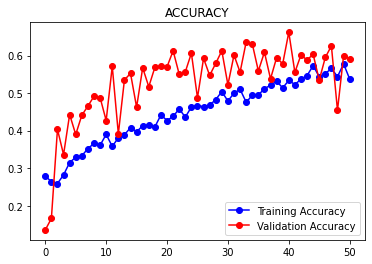

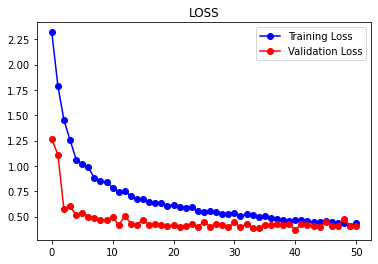

In [ ]:
import matplotlib.pyplot as plt

print(history.keys())
# see how the accuracy and the loss change during training
plt.title('ACCURACY')
plt.plot(history['accuracy'],'bo-',label = 'Training Accuracy')
plt.plot(history['val_accuracy'],'ro-',label = 'Validation Accuracy')
plt.legend()
plt.show()
plt.title('LOSS')
plt.plot(history['loss'],'bo-',label = 'Training Loss')
plt.plot(history['val_loss'],'ro-',label = 'Validation Loss')
plt.legend()
plt.show()

In [ ]:
y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
y_true_cat = np.argmax(y_true, -1)

In [ ]:
model = tf.keras.models.load_model("/content/drive/Shareddrives/DeepLearningProject/models/MobileNet/pretrained_MobileNet_model3_200c.h5")

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = model.predict(test_dataset, batch_size = 512, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
print('Accuracy on Test Data: %2.4f%%' % (accuracy_score(y_true_cat, pred_Y_cat)))
print(classification_report(y_true_cat, pred_Y_cat))

210/210 [==============================] - 211s 981ms/step
Accuracy on Test Data: 0.5639%
              precision    recall  f1-score   support

           0       0.74      0.74      0.74     39533
           1       0.07      0.08      0.07      3762
           2       0.14      0.09      0.11      7861
           3       0.02      0.01      0.01      1214
           4       0.02      0.09      0.04      1206

    accuracy                           0.56     53576
   macro avg       0.20      0.20      0.19     53576
weighted avg       0.57      0.56      0.57     53576



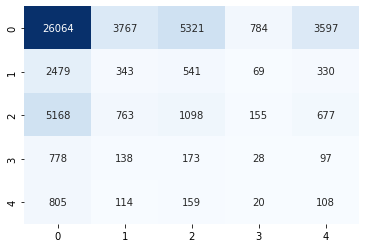

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_true_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)